<a id="top"></a>
# 03 - Solutions to Astroseismology and Other "Spurious" Signals
***
This notebook contains the solutions to the exercises contained in Lesson 3 on Asterseismology and Other "Spurious" Signals. We strongly encourage you to try the exercises yourself before looking at the solutions to get the most out of the practice. 

Click on the exercise number you are looking for the solution to in the table of contents below:
* [Exercise 1](#Exercise-1)
* [Exercise 2](#Exercise-2)
* [Exercise 3](#Exercise-3)

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

from astropy.table import Table, Column
from astroquery.mast import Mast
from astroquery.mast import Observations

# Working in the cloud
Observations.enable_cloud_dataset(provider='AWS')

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


## Exercise 1
Question: KIC 1161345 is another binary star system, this time with an even smaller period. Try importing its light curves and see if you can find the binary period.

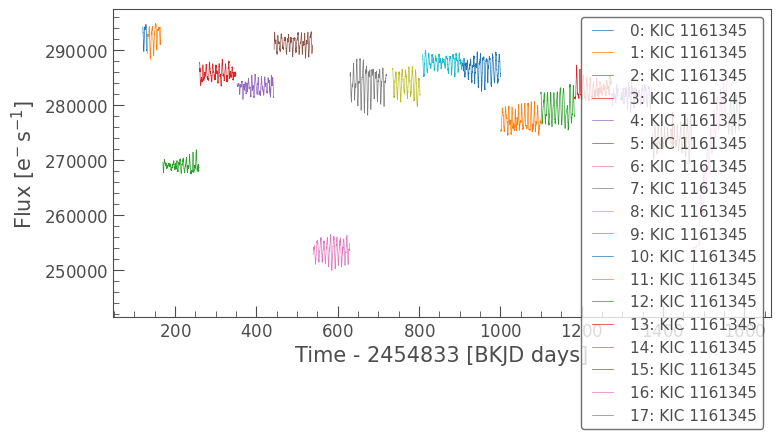

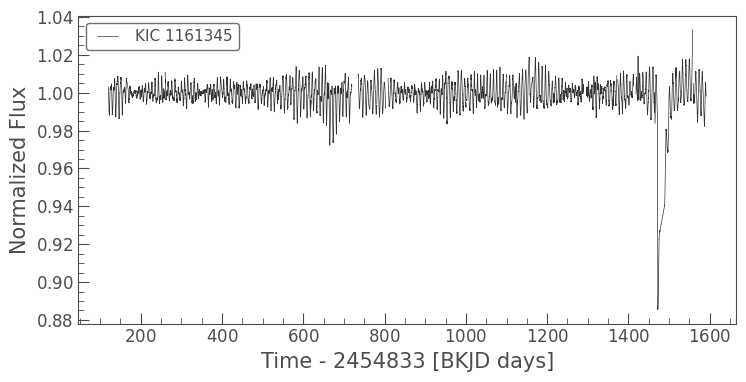

In [2]:
# Importing the data from the cloud
search_result = lk.search_lightcurve('KIC 1161345', author='Kepler', cadence='long')
lc_collection = search_result.download_all()
lc_collection.plot();

# Stitching the light curves together
lc = lc_collection.stitch().flatten(window_length=901)
lc.plot();

<Quantity 3.98184818 d>

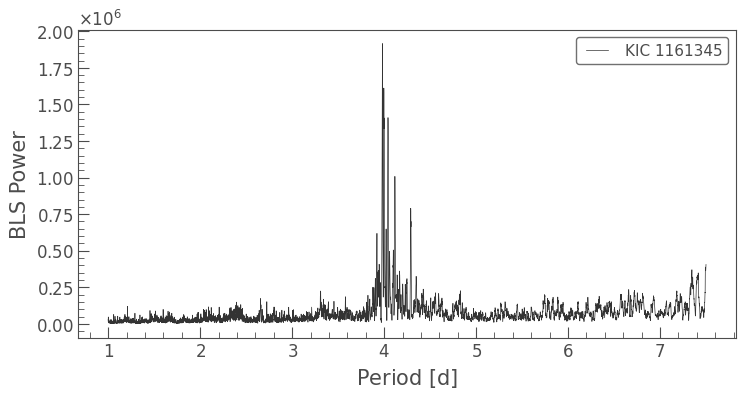

In [3]:
# Assigning period range as 1-7.5 because I gave the hint the period is known to be less than 8
period = np.linspace(1, 7.5, 10000)

# Turning the light curve into a peridogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

# Calculating the period of the binary stars as the 'planet b' that BLS is picking up on
planet_b_period = bls.period_at_max_power
planet_b_period

The exact period of this binary is 4.287456, so we got decently close for such a small period.

## Exercise 2
Question: Kepler-47 is one of the first discovered multiplanetary circumbinary system! This means that it has multiple exoplanets orbiting binary stars. Import the Kepler-47 data, subtract the binary primary and secondary eclipses, then search for the exoplanets. 

Hint: See if you can find three, one with a shorter period (< 50 days) and two with longer periods (> 150 days).

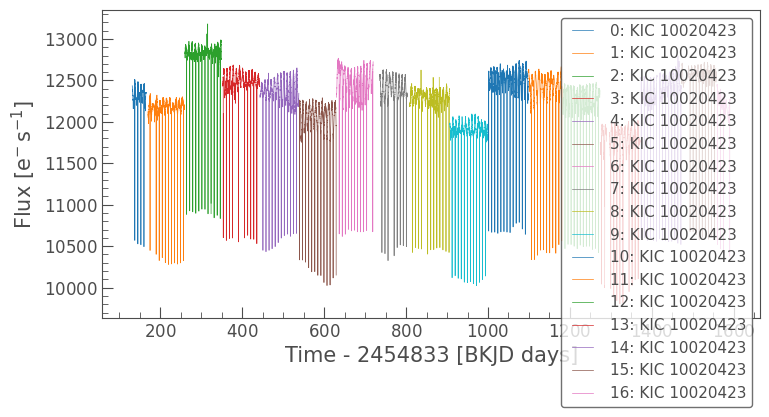

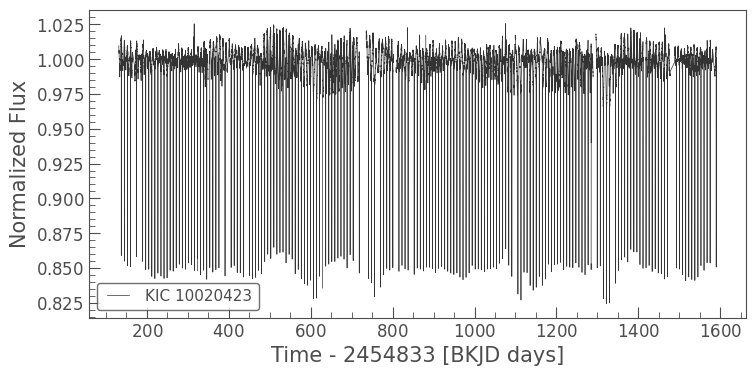

In [4]:
# Importing the light curve data and stitching it together
search_result = lk.search_lightcurve('Kepler 47', author='Kepler', cadence='long')
lc_collection = search_result.download_all()
lc_collection.plot();
lc = lc_collection.stitch().flatten(window_length=901)
lc.plot();

In [5]:
# Assigning the time and flux data points from the light curves to arrays
info = lc.normalize()
t = Table(rows=info, meta={'name': 'first table'})
cols = t.columns
flux = cols[1]
time = cols[0]
fluxes = flux.data
time_series = time.value

In [6]:
# Attemping to find the first primary eclipse time
first = []
for i in range(len(fluxes)):
    if flux[i] < 0.950 and time_series[i] < 150:
        first.append(time_series[i])
print(first)

[137.6422493053251, 137.66268358787056, 137.6831179702931, 137.70355245272367, 137.72398673515272, 137.74442111745884, 145.10079388150916, 145.12122834100592, 145.14166260037746, 145.16209695975704, 145.18253121901944, 145.2029656782761]


Notice that the first array contains two sets of values, one around 137 days and one around 145 days. Currently, the loop is picking up on two eclipse flux dips, not just the first one that we are searching for, so let's lower our time series bound to only catch the first one that we are after.

In [7]:
# Trying to find first primary eclipse time
first = []
for i in range(len(fluxes)):
    if flux[i] < 0.950 and time_series[i] < 140:
        first.append(time_series[i])
print(first)

# Averaging the time of the first primary eclipse
avg_time = sum(first)/len(first)
print(avg_time)

[137.6422493053251, 137.66268358787056, 137.6831179702931, 137.70355245272367, 137.72398673515272, 137.74442111745884]
137.693335194804


In [8]:
# Creating a primary eclipse mask that will tell if a flux dip occurs at the expected location
transit_occur = lc.create_transit_mask(transit_time=avg_time, period=7.448, duration=6)
print(transit_occur)
sum(transit_occur)

[ True  True  True ...  True  True  True]


52252

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

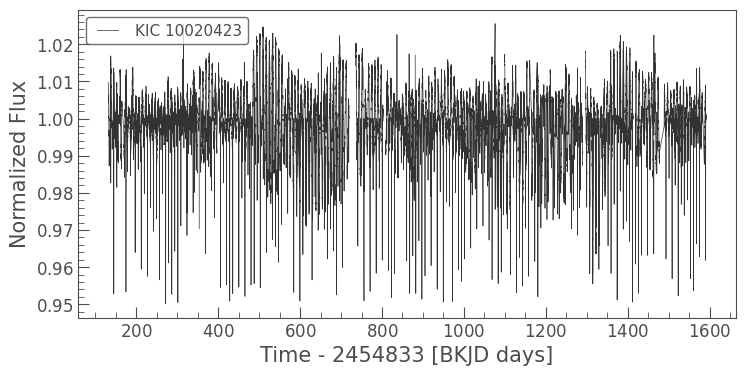

In [9]:
# Initializing an array for the fluxes that we will subtract the primary eclipse dips from
flux_array = lc.flux.value.tolist()

# Iterating through array of flux and if primary eclipse flux dip is detected, flux is added back to remove the dip
for i in range(len(flux_array)):
    if flux_array[i] < 0.950 and transit_occur[i] == True:
        flux_array[i] = flux_array[i] + np.absolute(flux_array[i] - 1)

lc.flux = flux_array
lc.plot()

In [10]:
# Trying to find first secondary eclipse time
second = []
for i in range(len(fluxes)):
    if flux[i] < 0.985 and time_series[i] < 140:
        second.append(time_series[i])
print(second)

# Averaging the time of the first primary eclipse
avg_time = sum(second)/len(second)
print(avg_time)

[137.6422493053251, 137.66268358787056, 137.6831179702931, 137.70355245272367, 137.72398673515272, 137.74442111745884, 137.764855599773]
137.70355239551387


In [11]:
# Creating a primary eclipse mask that will tell if a flux dip occurs at the expected location
transit_occur = lc.create_transit_mask(transit_time=avg_time, period=7.448, duration=6)
print(transit_occur)
sum(transit_occur)

[ True  True  True ...  True  True  True]


52254

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

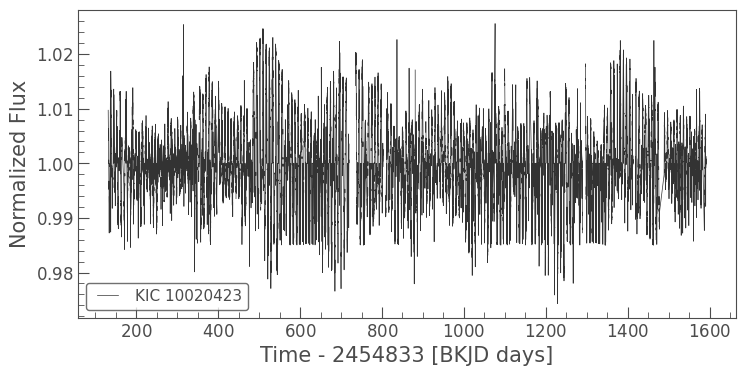

In [12]:
# Initializing an array for the fluxes that we will subtract the secondary eclipse dips from
flux_array = lc.flux.value.tolist()

# Iterating through array of flux and if secondary eclipse flux dip is detected, flux is added back to remove the dip
for i in range(len(flux_array)):
    if flux_array[i] < 0.985 and transit_occur[i] == True:
        flux_array[i] = flux_array[i] + np.absolute(flux_array[i] - 1)

lc.flux = flux_array
lc.plot()

<Quantity 46.68666867 d>

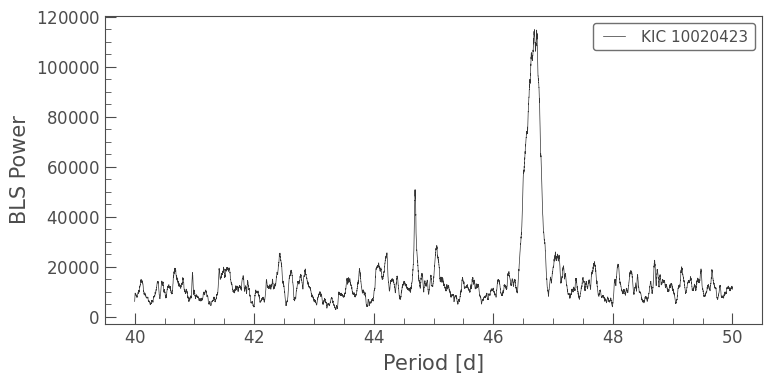

In [13]:
# Assigning period range off of hint, turning into periodogram
period = np.linspace(40, 50, 10000)
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

# Calculating most likely parameters of exoplanet
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power
planet_b_period

<Quantity 178.77287729 d>

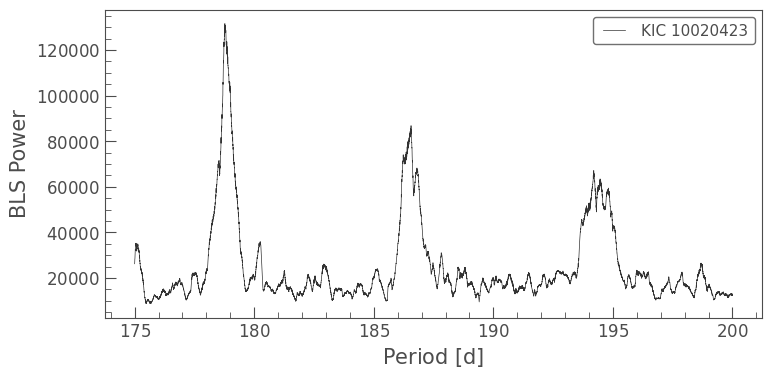

In [14]:
# Assigning period range off of hint, turning into periodogram
period = np.linspace(175, 200, 10000)
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

# Calculating most likely parameters of exoplanet
planet_c_period = bls.period_at_max_power
planet_c_t0 = bls.transit_time_at_max_power
planet_c_dur = bls.duration_at_max_power
planet_c_period

<Quantity 303.41734173 d>

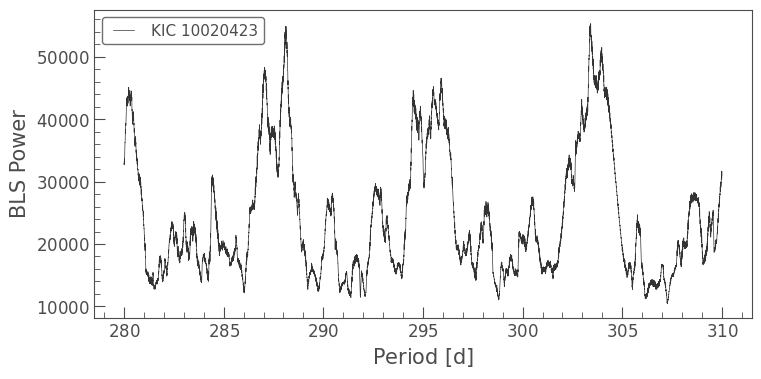

In [15]:
# Assigning period range off of hint, turning into periodogram
period = np.linspace(280, 310, 10000)
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

# Calculating most likely parameters off of exoplanet
planet_d_period = bls.period_at_max_power
planet_d_t0 = bls.transit_time_at_max_power
planet_d_dur = bls.duration_at_max_power
planet_d_period

The three circumbinary exoplanets officially have periods of 49.4643, 187.366, and 303.227. While not perfectly exact periods, we clearly are identifying the correct transits. 

Also, due to the difficulty in discovering the 187 period planet as it is a weaker signal, the 303 planet was actually discovered earlier. Due to exoplanet naming nomenclature dictating that the planets of a system are named in the order that they are found, from the stars out this system actually goes planet b, d, c (periods: 49, 187, 303). (Planet naming starts at the letter 'b' as the host star is considered to be the 'a' body.) 

## Exercise 3
Question: Kepler-64b is a planet that orbits within not just a binary system with two stars orbiting around each other, but a *quadruple* star system with four stars orbiting each other! See if you can subtract the quadruple influence and find the period of the exoplanet. When you think you have it, check your period [here](https://exoplanets.nasa.gov/resources/222/kepler-64b-four-star-planet/).

This exercise was left open-ended as a challenge to the reader, if you figured out a strategy that works, let us know!

## About this Notebook

**Author(s):** Larom Segev, Thomas Dutkiewicz <br>
**Keyword(s):** TIKE, AWS, Astroseismology, Binary stars, Exoplanet transits, Exercise answers <br>
**Last Updated:** July 2023 <br>
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 